### How does PDE dynamics change with synthetic timesteps?

In [1]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

# with h5py.File(f'data_large/Burgers_train_100000_default.h5', 'r') as f:
#     # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
#     traj = torch.tensor(f['train']['pde_140-256'][:1000, :131], dtype=torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
import hydra
from omegaconf import DictConfig, OmegaConf
from generate_data import evolve
from tqdm import tqdm

class Traj_dataset:
    traj_train = None
    traj_valid = None
    traj_test = None

def mean_std_normalize():
    assert Traj_dataset.traj_train is not None
    mean = Traj_dataset.traj_train[:32].mean()
    std = Traj_dataset.traj_train[:32].std()
    print(f'Mean: {mean}, Std: {std}')
    Traj_dataset.mean = 0.0
    Traj_dataset.std = 1.0

# def mean_std_normalize():
#     assert Traj_dataset.traj_train is not None
#     mean = Traj_dataset.traj_train[:32].mean()
#     std = Traj_dataset.traj_train[:32].std()
#     print(f'Mean: {mean}, Std: {std}')
#     Traj_dataset.mean = mean
#     Traj_dataset.std = std

def max_min_normalize():
    assert Traj_dataset.traj_train is not None
    max_val = Traj_dataset.traj_train[:32].max()
    min_val = Traj_dataset.traj_train[:32].min()
    mean = (max_val + min_val) / 2
    std = (max_val - min_val) / 2
    print(f'Max: {max_val}, Min: {min_val}')
    Traj_dataset.mean = mean
    Traj_dataset.std = std


hydra.initialize(config_path="cfg_long_hal", version_base=None)
cfg = hydra.compose(config_name="config", overrides=["task=KdV", "nt=14", "train.epochs=500", "initial_datasize=64"])


print('Loading training data...')
with h5py.File(cfg.dataset.train_path, 'r') as f:
    Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:cfg.datasize, :131], dtype=torch.float32)
print('Loading test data...')
with h5py.File(cfg.dataset.test_path, 'r') as f:
    Traj_dataset.traj_test = torch.tensor(f['test']['pde_140-256'][:cfg.testsize, :131], dtype=torch.float32)

if cfg.equation == 'Heat' or cfg.equation == 'KS':
    max_min_normalize()
else:
    mean_std_normalize()

Traj_dataset.traj_train = (Traj_dataset.traj_train - Traj_dataset.mean) / Traj_dataset.std
Traj_dataset.traj_test = (Traj_dataset.traj_test - Traj_dataset.mean) / Traj_dataset.std

Loading training data...
Loading test data...
Mean: 1.1197198723778001e-10, Std: 0.6562381386756897


Text(0.5, 1.0, 'Example trajectory of KdV')

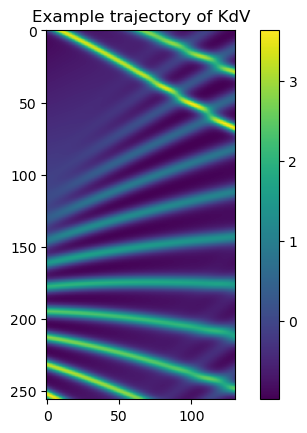

In [3]:
plt.figure()
plt.imshow(Traj_dataset.traj_train[0].cpu().numpy().T)
plt.colorbar()
plt.title(f'Example trajectory of {cfg.equation}')

In [ ]:
from torch.nn import functional as F
import torch.nn as nn

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, modes: int):
        super(SpectralConv1d, self).__init__()
        """
        Initializes the 1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        Args:
            in_channels (int): input channels to the FNO layer
            out_channels (int): output channels of the FNO layer
            modes (int): number of Fourier modes to multiply, at most floor(N/2) + 1    
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.scale = (1 / (in_channels*out_channels))
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat))

    def compl_mul1d(self, input: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
        """
        Complex multiplication of the Fourier modes.
        [batch, in_channels, x], [in_channel, out_channels, x] -> [batch, out_channels, x]
            Args:
                input (torch.Tensor): input tensor of size [batch, in_channels, x]
                weights (torch.Tensor): weight tensor of size [in_channels, out_channels, x]
            Returns:
                torch.Tensor: output tensor with shape [batch, out_channels, x]
        """
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Fourier transformation, multiplication of relevant Fourier modes, backtransformation
        Args:
            x (torch.Tensor): input to forward pass os shape [batch, in_channels, x]
        Returns:
            torch.Tensor: output of size [batch, out_channels, x]
        """
        batchsize = x.shape[0]
        # Fourier transformation
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes] = self.compl_mul1d(x_ft[:, :, :self.modes], self.weights)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


class FNO(nn.Module):
    def __init__(self,
                 time_history: int=1,
                 time_future: int=1,
                 modes: int = 32,
                 width: int = 256,
                 num_layers: int = 5
                 ):
        super(FNO, self).__init__()
        """
        Initialize the overall FNO network. It contains 5 layers of the Fourier layer.
        The input to the forward pass has the shape [batch, time_history, x].
        The output has the shape [batch, time_future, x].
        Args:
            pde (PDE): PDE at hand
            time_history (int): input timesteps of the trajectory
            time_future (int): output timesteps of the trajectory
            modes (int): low frequency Fourier modes considered for multiplication in the Fourier space
            width (int): hidden channel dimension
            num_layers (int): number of FNO layers
        """
        self.modes = modes
        self.width = width
        self.time_history = time_history
        self.time_future = time_future
        self.fc0 = nn.Linear(self.time_history + 2, self.width)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, self.time_future)

        fourier_layers = []
        conv_layers = []
        for i in range(num_layers):
            fourier_layers.append(SpectralConv1d(self.width, self.width, self.modes))
            conv_layers.append(nn.Conv1d(self.width, self.width, 1))
        self.fourier_layers = nn.ModuleList(fourier_layers)
        self.conv_layers = nn.ModuleList(conv_layers)

    def __repr__(self):
        return f'FNO1d'

    def forward(self, u: torch.Tensor, dx: torch.Tensor, dt: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of FNO network.
        The input to the forward pass has the shape [batch, time_history, x].
        1. Add dx and dt as channel dimension to the time_history, repeat for every x
        2. Lift the input to the desired channel dimension by self.fc0
        3. 5 (default) FNO layers
        4. Project from the channel space to the output space by self.fc1 and self.fc2.
        The output has the shape [batch, time_future, x].
        Args:
            u (torch.Tensor): input tensor of shape [batch, time_history, x]
            dx (torch.Tensor): spatial distances
            dt (torch.Tensor): temporal distances
        Returns: torch.Tensor: output has the shape [batch, time_future, x]
        """
        # TODO: rewrite training method and forward pass without permutation
        # [b, x, c] = [b, x, t+2]
        x = torch.cat((u, dx[:, None, None].to(u.device).repeat(1, 256, 1),
                       dt[:, None, None].repeat(1, 256, 1).to(u.device)), -1)

        x = self.fc0(x)
        # [b, x, c] -> [b, c, x]
        x = x.permute(0, 2, 1)

        for fourier, conv in zip(self.fourier_layers, self.conv_layers):
            x1 = fourier(x)
            x2 = conv(x)
            x = x1 + x2
            x = F.gelu(x)

        # [b, c, x] -> [b, x, c]
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)

        return x

In [4]:
import h5py
import torch
import numpy as np
# from neuralop.models import FNO
from tqdm import tqdm
import random

import argparse
import time

from eval_utils import compute_metrics
from utils import set_seed, flatten_configdict, trajectory_model, direct_model, split_model, normalized_model

unrolling = cfg.train.unrolling
nt = cfg.nt
ensemble_size = 5
num_acquire = cfg.num_acquire
device = cfg.device
epochs = cfg.train.epochs
lr = cfg.train.lr
batch_size = cfg.train.batch_size
initial_datasize = cfg.initial_datasize

def train(Y, train_nts, **kwargs):
    model = FNO(n_modes=tuple(cfg.model.n_modes), hidden_channels=64,
                in_channels=1, out_channels=1)
    model = model.to(device)
    # model = normalized_model(model, Traj_dataset.mean, Traj_dataset.std, Traj_dataset.mean, Traj_dataset.std)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.MSELoss()

    inputs = []
    outputs = []
    for b in range(Y.shape[0]):
        for t in range(train_nts[b].item()-1):
            inputs.append(Y[b,t])
            outputs.append(Y[b, t+1])
    inputs = torch.stack(inputs, dim=0).unsqueeze(1)
    outputs = torch.stack(outputs, dim=0).unsqueeze(1)

    dataset = torch.utils.data.TensorDataset(inputs, outputs)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in tqdm(range(epochs)):
        model.train()
        # max_unrolling = epoch if epoch <= unrolling else unrolling
        # unrolling_list = [r for r in range(max_unrolling + 1)]

        total_loss = 0
        for x, y in dataloader:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            
            pred = model(x)
            loss = criterion(pred, y)

            # loss = torch.sqrt(loss)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        # wandb.log({f'train/loss_{acquire_step}': total_loss})
    return model

timestep = (Traj_dataset.traj_train.shape[1] - 1) // (nt - 1) # 10
Y = Traj_dataset.traj_train[:,0::timestep]
train_nts = torch.zeros(Y.shape[0], device=device).int()
train_nts[:initial_datasize] = nt
# model = train(Y, train_nts)
ensemble = [train(Y, train_nts) for _ in range(ensemble_size)]

100%|██████████| 500/500 [04:02<00:00,  2.07it/s]


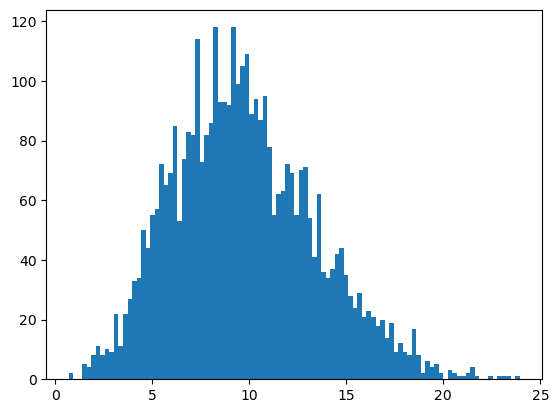

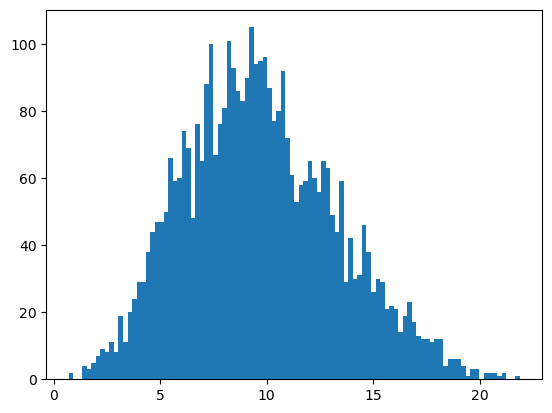

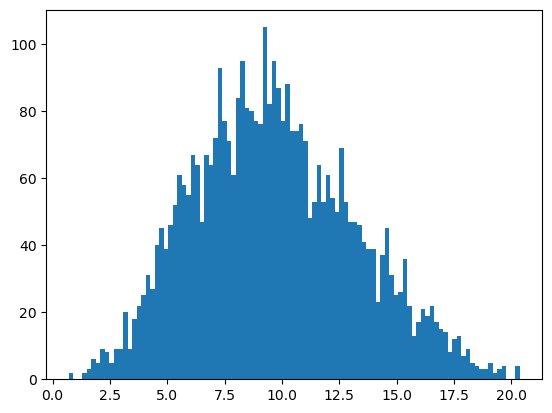

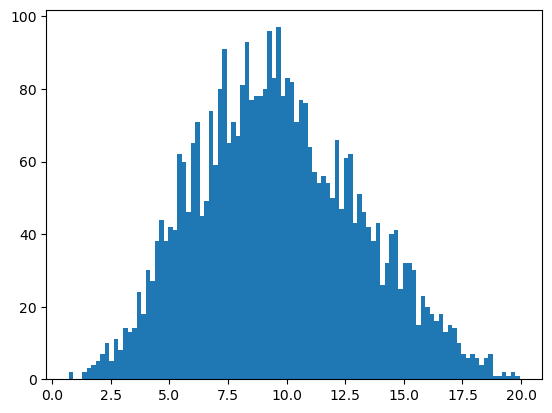

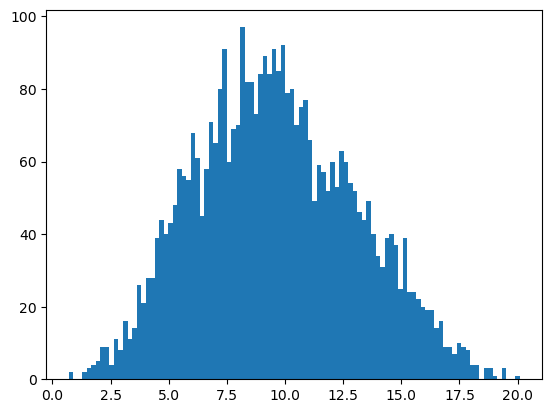

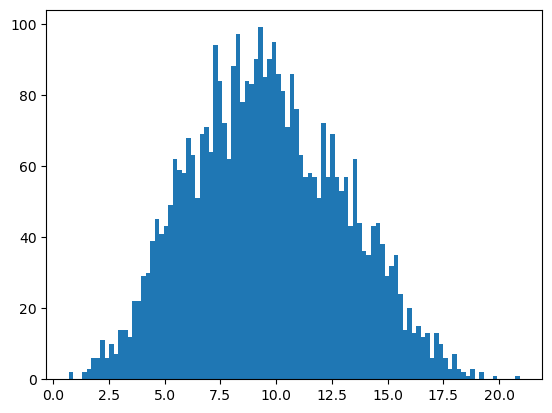

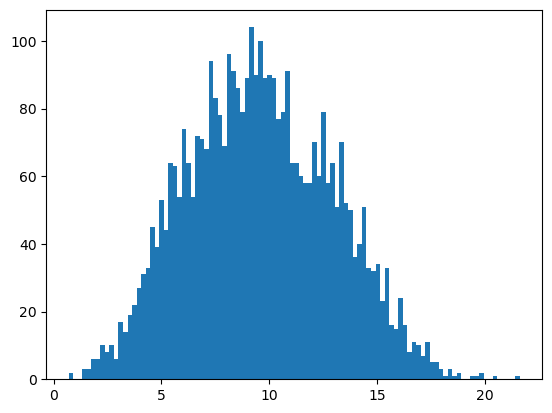

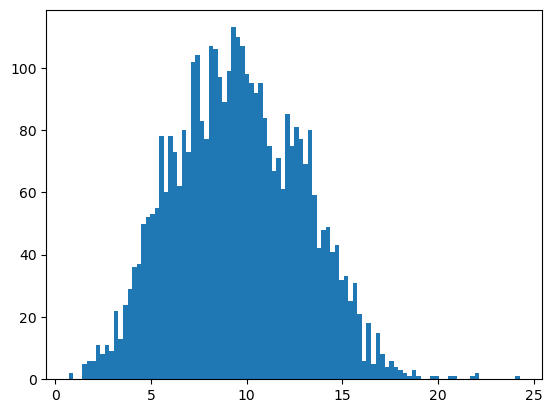

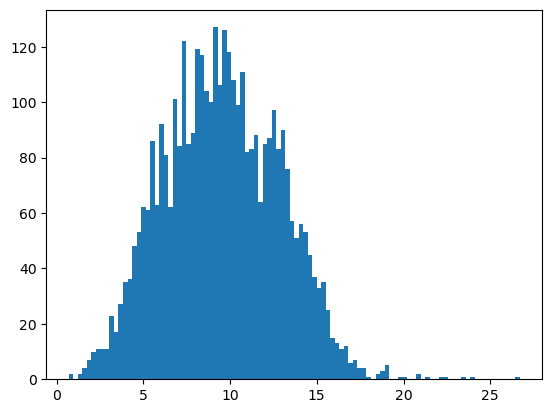

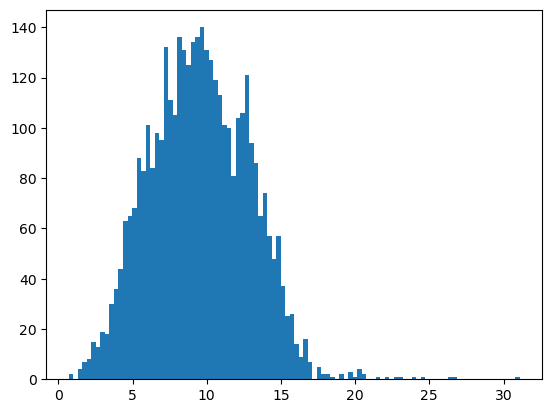

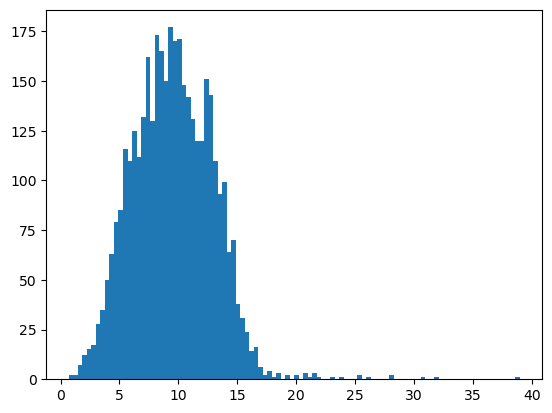

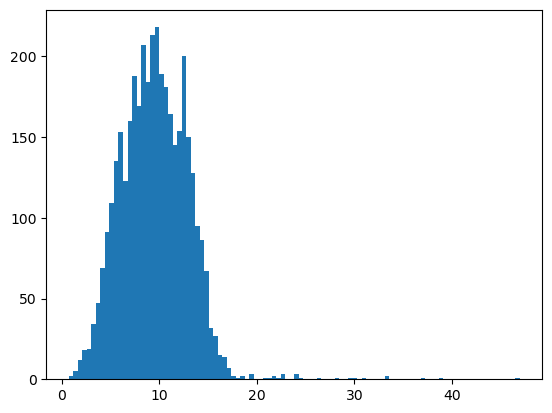

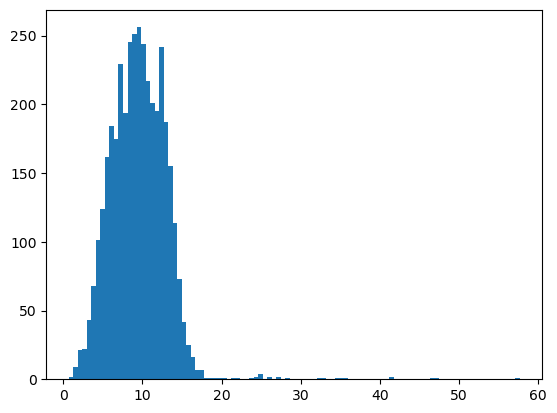

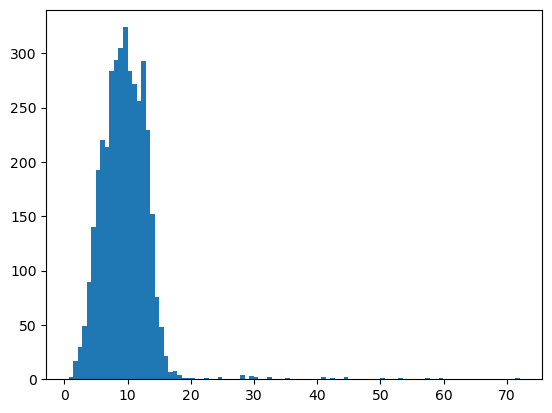

In [5]:
from generate_data import evolve
from utils import split_model, torch_expand

for model in ensemble:
    model.eval()

X = Y[256:, 0:1]
# with torch.no_grad():

#     preds = [torch_expand(X[:,None], 1, len(ensemble))] # [datasize, ensemble_size, 1, nx]
#     for t in range(nt-1):
#         X_t = preds[-1].clone()
#         X_t = torch.stack([split_model(model, cfg.eval_batch_size)(X_t[:, i].to(device)).cpu() for i, model in enumerate(ensemble)], dim=1) # [datasize, ensemble_size, 1, nx] 
#         preds.append(X_t)
#     mean = torch.cat(preds, dim=2).mean(dim=1) # [datasize, nt, nx]
#     # variance = torch.cat(preds, dim=2).var(dim=1) # [datasize, nt, nx]
#     # variance_per_data = variance.mean(dim=(1,2)) # [datasize]
#     # norm_per_data = torch.norm(mean, dim=(1,2)) # [datasize]
#     # rel = variance_per_data / norm_per_data # [datasize]
#     # ready = rel < 0.2 # [datasize]
#     ready = torch.max(mean, dim=2).values.max(dim=1).values.abs() < 4
#     print(f'Ready: {ready.sum().item()} out of {X.shape[0]}')

ready = torch.ones(X.shape[0]).bool()

model = ensemble[0]
with torch.no_grad():
    X_t = X[ready]
    X_t = X_t.to(device)
    norms=X_t.norm(dim=tuple(range(2, X_t.dim())))
    plt.figure()
    plt.hist(norms.cpu().numpy(), bins=100)
    # print(x.max())
    traj = [X_t]
    for t in range(nt-1):
        # if t%15 == 0:
        if False:
            x = evolve(x, cfg).to(device)
        else:
            prev_norm = X_t.norm(dim=tuple(range(2, X_t.dim())), keepdim=True)
            X_t = split_model(model, 256)(X_t)
            # x = x / x.norm(dim=tuple(range(2, x.dim())), keepdim=True) * prev_norm
        norms=X_t.norm(dim=tuple(range(2, X_t.dim())))
        plt.figure()
        plt.hist(norms.cpu().numpy(), bins=100)
        # print(x.max())
        traj.append(X_t)
    
traj_single = torch.cat(traj, dim=1)


In [6]:
from generate_data import evolve
from utils import split_model, torch_expand

for model in ensemble:
    model.eval()

X = Y[256:, 0:1]
# with torch.no_grad():

#     preds = [torch_expand(X[:,None], 1, len(ensemble))] # [datasize, ensemble_size, 1, nx]
#     for t in range(nt-1):
#         X_t = preds[-1].clone()
#         X_t = torch.stack([split_model(model, cfg.eval_batch_size)(X_t[:, i].to(device)).cpu() for i, model in enumerate(ensemble)], dim=1) # [datasize, ensemble_size, 1, nx] 
#         preds.append(X_t)
#     mean = torch.cat(preds, dim=2).mean(dim=1) # [datasize, nt, nx]
#     # variance = torch.cat(preds, dim=2).var(dim=1) # [datasize, nt, nx]
#     # variance_per_data = variance.mean(dim=(1,2)) # [datasize]
#     # norm_per_data = torch.norm(mean, dim=(1,2)) # [datasize]
#     # rel = variance_per_data / norm_per_data # [datasize]
#     # ready = rel < 0.2 # [datasize]
#     ready = torch.max(mean, dim=2).values.max(dim=1).values.abs() < 4
#     print(f'Ready: {ready.sum().item()} out of {X.shape[0]}')

ready = torch.ones(X.shape[0]).bool()

traj_ensemble = []
for i in range(ensemble_size):
    with torch.no_grad():
        model = ensemble[i]
        X_t = X[ready]
        X_t = X_t.to(device)
        norms=X_t.norm(dim=tuple(range(2, X_t.dim())))
        # print(x.max())
        traj = [X_t]
        for t in range(nt-1):
            # if t%15 == 0:
            if False:
                x = evolve(x, cfg).to(device)
            else:
                prev_norm = X_t.norm(dim=tuple(range(2, X_t.dim())), keepdim=True)
                X_t = split_model(model, 256)(X_t)
                # x = x / x.norm(dim=tuple(range(2, x.dim())), keepdim=True) * prev_norm
            norms=X_t.norm(dim=tuple(range(2, X_t.dim())))
            # print(x.max())
            traj.append(X_t)
    traj_ensemble.append(torch.cat(traj, dim=1))
traj_ensemble = torch.stack(traj_ensemble, dim=0).mean(dim=0)



In [7]:
real_traj = Y[256:][ready, :traj.shape[1]]
print(traj.shape, real_traj.shape)
assert real_traj.shape == traj.shape

print('Computing metrics...')
metrics = compute_metrics(real_traj.flatten(1), traj.flatten(1))
print(metrics[0].mean())
print(metrics[1].mean())
print(metrics[2].mean())

AttributeError: 'list' object has no attribute 'shape'

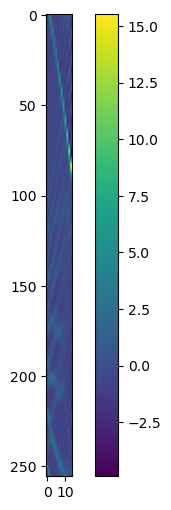

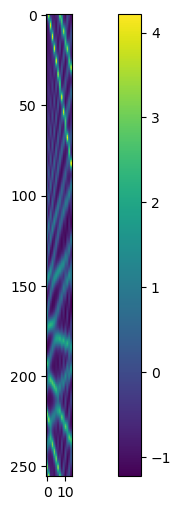

In [ ]:
idx = 2252
plt.figure()
plt.imshow(traj[idx].cpu().numpy().T)
plt.colorbar()


plt.figure()
plt.imshow(real_traj[idx].cpu().numpy().T)
plt.colorbar()